In [9]:
import random
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
# Realizar Grid Search
from itertools import product



# Seed all possible
seed_ = 935115
random.seed(seed_)
np.random.seed(seed_)
torch.manual_seed(seed_)

# If using CUDA, you can set the seed for CUDA devices as well
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_)
    torch.cuda.manual_seed_all(seed_)
    
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
intervals = [2, 4, 6, 8, 10]
for months in intervals:
        # Load saved data and create train-test split for each month interval
    data = pd.read_csv(f'../data/PROCESS/processed_tch_prediction_data_{months}Mesv7.csv')

    # Create a mask for ZAFRA 23-24
    mask_22_23 = data['ZAFRA'] == '23-24'

    # Split the data
    X_train = data[~mask_22_23].drop('TCH', axis=1)
    y_train = data[~mask_22_23]['TCH']
    X_test = data[mask_22_23].drop('TCH', axis=1)
    y_test = data[mask_22_23]['TCH']

    # Drop unnecessary columns
    X_train = X_train.drop(columns=['ABS_IDCOMP', 'ZAFRA','fecha','rendimiento'])
    X_test = X_test.drop(columns=['ABS_IDCOMP', 'ZAFRA','fecha','rendimiento'])

    # Save train and test datasets to CSV
    data[~mask_22_23].drop(columns=['ABS_IDCOMP', 'ZAFRA','fecha','rendimiento']).to_csv(f'../data/UP/TRAIN_{months}Mesv7.csv', index=False)
    data[mask_22_23].drop(columns=['ABS_IDCOMP', 'ZAFRA','fecha','rendimiento']).to_csv(f'../data/UP/TEST_{months}Mesv7.csv', index=False)

In [11]:
data = pd.read_csv('../data/PROCESS/encoded_tch_prediction_data_zafrav3.2.csv')

# Create a mask for ZAFRA 22-23
mask_22_23 = data['ZAFRA'] == '23-24'

# Split the data
X_train = data[~mask_22_23].drop('TCH', axis=1)
y_train = data[~mask_22_23]['TCH']
X_test = data[mask_22_23].drop('TCH', axis=1)
y_test = data[mask_22_23]['TCH']

X_train = X_train.drop(columns=['ABS_IDCOMP','ZAFRA'])
y_train = y_train.drop(columns=['ABS_IDCOMP','ZAFRA'])
X_test = X_test.drop(columns=['ABS_IDCOMP','ZAFRA'])
y_test = y_test.drop(columns=['ABS_IDCOMP','ZAFRA'])

print("\nZAFRA Split:")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

data[~mask_22_23].to_csv('../data/UP/TRAIN.csv',index=False)
data[mask_22_23].to_csv('../data/UP/TEST.csv',index=False)



ZAFRA Split:
Training set shape: (11480, 93)
Testing set shape: (1805, 93)


In [12]:

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

X_train = X_train_tensor 
y_train = y_train_tensor
X_test = X_test_tensor
y_test = y_test_tensor

In [13]:
# Dividir X_test en X_val y X_test
X_val_tensor, X_test_tensor, y_val_tensor, y_test_tensor = train_test_split(
    X_test_tensor, y_test_tensor, test_size=0.5, random_state=42)



In [14]:



# Definir la función para calcular R^2
def calculate_r2(y_true, y_pred):
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    return r2.item()

# Clase Net (la misma que proporcioné antes)
class Net(nn.Module):
    def __init__(self, input_size,N=16):
        super(Net, self).__init__()
        
        output_size = 1  # Para regresión
        
        # Definir el tamaño máximo como un múltiplo del tamaño de entrada
        peak_size = input_size * 4  # Ajustar el multiplicador según sea necesario
        
        # Inicializar la lista de tamaños de capas
        layer_sizes = []
        
        # Capas ascendentes
        for i in range(N // 2):
            size = input_size + int((peak_size - input_size) * (i + 1) / (N // 2))
            layer_sizes.append(size)
        
        # Capas descendentes
        for i in range(N // 2):
            size = peak_size - int((peak_size - output_size) * (i + 1) / (N // 2))
            layer_sizes.append(size)
        
        # Definir las capas
        self.layers = nn.ModuleList()
        prev_size = input_size
        for size in layer_sizes:
            self.layers.append(nn.Linear(prev_size, size))
            prev_size = size
        self.layers.append(nn.Linear(prev_size, output_size))  # Capa de salida
        
        print(layer_sizes)
        
        # Activaciones
        self.sigmoid = nn.Sigmoid()
        self.leaky_relu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        N = len(self.layers)
        for i, layer in enumerate(self.layers[:-1]):  # Excluir la última capa
            x = layer(x)
            
            # Activaciones: sigmoid al principio, luego leaky ReLU, luego ReLU
            if i < N // 3:
                x = self.sigmoid(x)
            elif i < 2 * N // 3:
                x = self.leaky_relu(x)
            else:
                x = self.relu(x)
            
            # Dropout cada dos capas ocultas
            if (i + 1) % 2 == 0:
                x = self.dropout(x)
        
        # Capa final sin activación (para regresión)
        x = self.layers[-1](x)
        return x

    # Función de pérdida L1
    def l1_loss(self):
        l1_loss = 0
        for param in self.parameters():
            l1_loss += torch.sum(torch.abs(param))
        return l1_loss

    # Función de pérdida L2
    def l2_loss(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.sum(param.pow(2))
        return l2_loss


# Definir una función para entrenar el modelo con hiperparámetros específicos
def train_model(model, criterion, optimizer, scheduler,
                X_train, y_train, X_val, y_val,
                num_epochs=100, l1_lambda=0.01, l2_lambda=0.01,
                early_stopping_patience=10, batch_size=32, writer=None):

    # Initialize variables for early stopping
    mini_best_val_loss = np.inf
    patience_counter = 0
    # mini_best_model_state = None

    # Create DataLoader for batch handling
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # l1_reg = l1_lambda * model.l1_loss()
            # l2_reg = l2_lambda * model.l2_loss()
            # loss = loss + l1_reg + l2_reg
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Update learning rate
        scheduler.step()
        
        # Validation evaluation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_r2 = calculate_r2(y_val, val_outputs)
        
        # Log to TensorBoard
        if writer:
            writer.add_scalar('Loss/train', epoch_loss / len(train_loader), epoch)
            writer.add_scalar('Loss/val', val_loss.item(), epoch)
            writer.add_scalar('R2/val', val_r2, epoch)
            writer.add_scalar('Learning Rate', scheduler.get_last_lr()[0], epoch)
        
        # Early Stopping
        if val_loss.item() < mini_best_val_loss:
            mini_best_val_loss = val_loss.item()
            patience_counter = 0
            # Save the best model state
            mini_best_model_state = model.state_dict()
        else:
            patience_counter += 1
        
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
        
        # Display metrics every 50 epochs
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], LR: {scheduler.get_last_lr()[0]:.6f}, '
                  f'Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}, '
                  f'Val R^2: {val_r2:.4f}')
    
    # Load the best model state
    model.load_state_dict(mini_best_model_state)
    
    return model

# Definir los hiperparámetros para el Grid Search
param_grid = {
    'learning_rate': [0.1,0.01, 0.001],
    'l1_lambda': [0.0, 0.001],
    'l2_lambda': [0.0, 0.001],
    'batch_size': [1024],
    'num_epochs': [200],
    'optimizer_type': ['Adam', 'SGD'],
    'criterion': ['MSE', 'MAE','SmoothL1Loss'],
}
# Obtener todas las combinaciones de hiperparámetros
keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_combinations = [dict(zip(keys, combination)) for combination in product(*values)]

best_model = None
best_val_r2 = -np.inf
best_params = None
best_model_state = None


In [46]:

# Realizar Grid Search
from itertools import product


for params in param_combinations:
    print(f"Evaluating combination: {params}")
    
    # Crear nuevo modelo
    input_size = X_train_tensor.shape[1]
    model = Net(input_size)
    
    # Definir criterio y optimizador según los parámetros
    if params['criterion'] == 'MSE':
        criterion = nn.MSELoss()
    elif params['criterion'] == 'MAE':
        criterion = nn.L1Loss()
    elif params['criterion'] == 'SmoothL1Loss':
        criterion = nn.SmoothL1Loss()
    
    if params['optimizer_type'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer_type'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9)
    
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    
    # Inicializar TensorBoard
    writer = SummaryWriter(comment=f"LR_{params['learning_rate']}_L1_{params['l1_lambda']}_L2_{params['l2_lambda']}_BS_{params['batch_size']}_OPT_{params['optimizer_type']}")
    
    # Entrenar el modelo
    trained_model = train_model(
        model, criterion, optimizer, scheduler,
        X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor,
        num_epochs=params['num_epochs'],
        l1_lambda=params['l1_lambda'],
        l2_lambda=params['l2_lambda'],
        batch_size=params['batch_size'],
        writer=writer
    )
    
    # Evaluar en el conjunto de validación
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_r2 = calculate_r2(y_val_tensor, val_outputs)
    
    print(f"Validation R^2: {val_r2:.4f}")
    
    # Cerrar el escritor de TensorBoard
    writer.close()
    
    # Guardar el mejor modelo
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        best_model = trained_model
        best_params = params
        best_model_state = trained_model.state_dict()

print(f"Best Validation R^2: {best_val_r2:.4f} with parameters {best_params}")

# Evaluar el mejor modelo en el conjunto de prueba
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test_tensor)
    test_r2 = calculate_r2(y_test_tensor, test_outputs)
    test_loss = nn.MSELoss()(test_outputs, y_test_tensor)

print(f"Test Loss: {test_loss.item():.4f}, Test R^2: {test_r2:.4f}")


Evaluating combination: {'learning_rate': 0.1, 'l1_lambda': 0.0, 'l2_lambda': 0.0, 'batch_size': 1024, 'num_epochs': 200, 'optimizer_type': 'Adam', 'criterion': 'MSE'}
Epoch [50/200], LR: 0.010000, Train Loss: 4966.5267, Val Loss: 4928.9785, Val R^2: -8.2665
Epoch [100/200], LR: 0.000100, Train Loss: 4745.6200, Val Loss: 4746.7148, Val R^2: -7.9239
Epoch [150/200], LR: 0.000001, Train Loss: 4767.2532, Val Loss: 4743.2217, Val R^2: -7.9173
Early stopping at epoch 160
Validation R^2: -7.9173
Evaluating combination: {'learning_rate': 0.1, 'l1_lambda': 0.0, 'l2_lambda': 0.0, 'batch_size': 1024, 'num_epochs': 200, 'optimizer_type': 'Adam', 'criterion': 'MAE'}
Epoch [50/200], LR: 0.010000, Train Loss: 53.1948, Val Loss: 49.5514, Val R^2: -4.6155
Epoch [100/200], LR: 0.000100, Train Loss: 51.1866, Val Loss: 47.2790, Val R^2: -4.1979
Epoch [150/200], LR: 0.000001, Train Loss: 51.0880, Val Loss: 47.2375, Val R^2: -4.1904
Early stopping at epoch 160
Validation R^2: -4.1904
Evaluating combination

UnboundLocalError: local variable 'mini_best_model_state' referenced before assignment

In [15]:
best_params = {'learning_rate': 0.001, 'l1_lambda': 0.0, 'l2_lambda': 0.001, 'batch_size': 1024, 'num_epochs': 200, 'optimizer_type': 'SGD'}
input_size = X_train_tensor.shape[1]
model = Net(input_size,4)

# Definir criterio y optimizador según los parámetros
criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'], momentum=0.9)

scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Inicializar TensorBoard
writer = SummaryWriter(comment="FINAL MODEL")

# Entrenar el modelo
trained_model = train_model(
    model, criterion, optimizer, scheduler,
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    num_epochs=best_params['num_epochs'],
    l1_lambda=best_params['l1_lambda'],
    l2_lambda=best_params['l2_lambda'],
    batch_size=2048,
    writer=writer
)

# Evaluar en el conjunto de validación
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    val_r2 = calculate_r2(y_val_tensor, val_outputs)
    val_rmse = torch.sqrt(criterion(val_outputs, y_val_tensor))
print(f"Validation RMSE: {val_rmse:.4f}")

    

print(f"Validation R^2: {val_r2:.4f}")


# Cerrar el escritor de TensorBoard
writer.close()
 





[232, 372, 187, 1]
Epoch [50/200], LR: 0.000100, Train Loss: 410.9633, Val Loss: 532.2156, Val R^2: -0.0006
Epoch [100/200], LR: 0.000001, Train Loss: 410.7617, Val Loss: 532.0065, Val R^2: -0.0002
Early stopping at epoch 130
Validation RMSE: 23.0652
Validation R^2: -0.0002


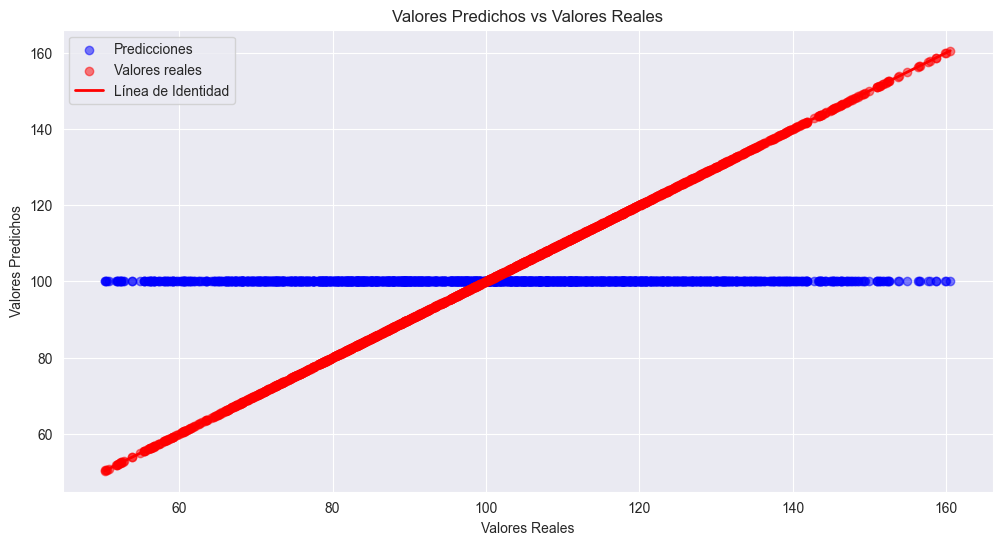

In [16]:

model.eval()

with torch.no_grad():
    predictions = model(X_test).cpu().detach().numpy()
    y_test_np = y_test.cpu().detach().numpy()  # Convertir y_test a Numpy array

plt.figure(figsize=(12, 6))

# Gráfico de dispersión para las predicciones
plt.scatter(y_test_np, predictions, alpha=0.5, color='blue', label='Predicciones')

# Gráfico de dispersión para los valores reales (diagonal)
plt.scatter(y_test_np, y_test_np, alpha=0.5, color='red', label='Valores reales')

# Línea de identidad para referencia visual
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r', lw=2, label='Línea de Identidad')

# Añadiendo etiquetas y leyenda
plt.title('Valores Predichos vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.legend()

# Mostrar la gráfica
plt.show()

In [40]:
predictions

array([[101.24754],
       [101.24754],
       [101.24754],
       ...,
       [101.24754],
       [101.24754],
       [101.24754]], dtype=float32)

  0%|          | 0/100 [00:00<?, ?it/s]

D:\Proyectos\PANTALEON\Pruebas\.venv\lib\site-packages\shap\plots\_beeswarm.py:600: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))


<Figure size 1000x600 with 0 Axes>

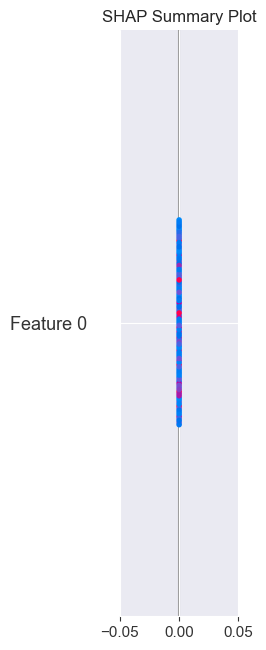

In [22]:
import shap
import numpy as np
import matplotlib.pyplot as plt

def explain_pytorch_model(model, X_train, X_val):
    # Poner el modelo en modo evaluación
    model.eval()
    
    # Crear una función que convierta los inputs de numpy a PyTorch y obtenga predicciones
    def predict(x):
        x_tensor = torch.Tensor(x)
        with torch.no_grad():
            return model(x_tensor).detach().numpy()
    
    # Crear el explainer de SHAP
    # Usamos una muestra del conjunto de entrenamiento como background
    background = X_train.detach().numpy()[:100]  # Tomamos 100 muestras como background
    explainer = shap.KernelExplainer(predict, background)
    
    # Calcular valores SHAP para el conjunto de validación
    # Tomamos una muestra para el análisis si el conjunto es muy grande
    n_samples = min(100, X_val.shape[0])  # Limitamos a 100 muestras para eficiencia
    X_val_sample = X_val.detach().numpy()[:n_samples]
    
    # Calcular valores SHAP
    shap_values = explainer.shap_values(X_val_sample)
    
    # Crear el summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_val_sample, show=False)
    plt.title('SHAP Summary Plot')
    plt.tight_layout()
    plt.show()
    
    return explainer, shap_values

# Usar la función con tu modelo
explainer, shap_values = explain_pytorch_model(model, X_train_tensor, X_val_tensor)

# Si quieres guardar el gráfico en TensorBoard
figure = plt.gcf()
writer.add_figure('SHAP/summary_plot', figure)